<a href="https://colab.research.google.com/github/ronald-hk-chung/ssnotebook/blob/main/computer_vision/googlenet_cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building GoogleNet (Inception V1) to train on Cifar100

**Mission Statement**

1. Building a GoogleNet(Inception V1) from scratch
2. Train GoogleNet on Cifar-100 Dataset

## Notebook Preperation

In [1]:
!pip install -q git+https://github.com/ronald-hk-chung/sstorch.git

from sstorch.learner import SSTLearner
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchinfo

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


## Introduction to GoogleNet (Inception V1)

GoogleNet, released in 2014, was proposed by resaerch at Google (with the collaboration of various universities) in the research paper titled [Going Deeper with Convolution](https://arxiv.org/pdf/1409.4842). It set a new benchmark in object classification and detection through it sinnovative approach in ImageNet Large Scale Visual Recognition Challenge (ILSVRC) and achieve a top-5 error rate of 6.7%)

GoogleNet model is particularly known for its use of Inception modules, which serve as its building blocks by using parallel convolutions wiht various filter sizes (1x1, 3x3 and 5x5) with in a single layer. The outputs from these filters are then concatenated - the fusion of outputs from various filters creates a richer representation.

While the architecture is relatively deep with 22 layers, the model maintains computational efficiency despite the increase in the number of layers.

Below list the key features of GoogleNet:

*   Inception Module with The 1x1 Convolution
*   Global Average Pooling
*   Auxilliary Classifier for Training

In the below architecture, every box represents a layer

*   **Blue Box** - Convolutional Layer
*   **Green Box** - Feature Concatenation
*   **Red Box** - MaxPool Layer
*   **Yellow Box** - Softmax Layer

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/googlenet.png?raw=true">


Below shows the details of architecture of GoogleNet

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/googlenet_architecture.png?raw=true">

<br/>

**Characteristics and features of GoogleNet configuration table**

*   The input layer of the GoogLeNet architecture takes in an image of the dimension 224 x 224.
*   **Type:** This refers to the name of the current layer of the component within the architecture
*   **Patch Size:** Refers to the size of the sweeping window utilised across conv and pooling layers. Sweeping windows have equal height and width.
*   **Stride:** Defines the amount of shift the filter/sliding window takes over the input image.
*   **Output Size:** The resulting output dimensions(height, width, number of feature maps) of the current architecture component after the input is passed through the layer.
*   **Depth:** Refer to the number of levels/layers within an architecture component.
*   **#1x1 #3x3 #5x5:** Refers to the various convolutions filters used within the inception module.
*   **#3X3 reduce #5x5 reduce:** Refers to the numbers of 1x1 filters used before the convolutions.
*   **Pool Proj:** This is the number of 1x1 filters used after pooling within an inception module.
*   **Params:** Refers to the number of weights within the current architecture component.
*   **Ops:** Refers to the number of mathematical operations carried out within the component.

## Inception Module

The Inception Module is the building block of GoogleNet, as the entire model is made by stacking Inception Modules. Key features include:

*   **Multi-Level Feature Extraction**:

    Image object can have large variation in size. Because of such variation in images, choosing the right kernel size for performing convolution operation becomes very difficult. A larger kernel is needed to extract information of object that is distributed more in teh picture while a smaller kernel is preferred to extract information of image that is distributed less in the picture. The major approach to increase the performace of neural networks is by increasing its size and depth with the downside of overfitting and increased computational resources. GoogleNet comes up with a novel solution to form a *wider* networker rather than *depper* which is called as Inception module. Inception module consists of multiple pooling and convolution operations with different kernel sizes in parallel, instead of using just one filter of a single size. Below shows teh naive version of the Inception module.

    <img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/inception_module_naive.png?raw=true">

    The 'naive' incpetion module performs convolutions on input from previous layer, with 3 different size of kernels or filters specifically 1x1, 3x3 and 5x5. Max pooling is then performed with outputs then concatenated and sent to the next inception module.

*   **Dimension Reduction**:

    Stacking multiple layers of the `naive` inception module can increased computations significantly. To overcome this, the researchers incorporate 1x1 convolution before feeding the data into 3x3 or 5x5 convolutions.

    <img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/inception_module_reduction.png?raw=true">

    By using 1x1 convolution, teh module reduces dimensionlaity before applying the more expensive 3x3 and 5x5 convolutions and pooling operations.

    it also results in better representation by incorporating filters of varying sizes and more layers which the network will be able to capture wider range of features in the input data

    The 1x1 convsolution is also called network in teh network as it act as a mcro-neural netowkr that learns to abstract the data before the main convolution filters are applied.



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, List, Optional, Tuple

class BasicConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs: Any) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

class Inception(nn.Module):
    def __init__(self,
                 in_channels: int,
                 ch1x1: int,
                 ch3x3red: int,
                 ch3x3: int,
                 ch5x5red: int,
                 ch5x5: int,
                 pool_proj: int):
        super().__init__()

        conv_block = BasicConv2d    #Conv2d -> BatchNorm2d -> ReLU

        self.branch1 = conv_block(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, ch3x3red, kernel_size=1),
            conv_block(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, ch5x5red, kernel_size=1),
            conv_block(ch5x5red, ch5x5, kernel_size=3, padding=1)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            conv_block(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        return torch.cat([branch1, branch2, branch3, branch4], 1)

## Auxiliary Classifier for Training

GoogleNet added intermediate classifiers on the side of the network. One important thing to note is that these are only used during training and in the inference, these are omitted.

Auxiliary classifiers help overcome the challenges of training very Deep Neural Networks and vanishing gradients (when the gradients turn into extremely small values)

In the GoogleNet architecture, there are two auxiliary classifiers in the network. They are placed strategically, where the depth of the feature extracted is sufficient to make a meaningful impact, but before the final prediction from teh output classifier.

The structure of each auxiliary classifier is mentioned below:

*   An average pooling layer with a 5x5 window and stride 3
*   A 1x1 convolution for dimension reduction with 128 filters
*   Two fully connected layers, the first layer with 1024 units, followed by a dropout layer and the final layer corresponding to the number of classes in the task.
*   A SoftMax layer to output the prediction probabilities

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/auxiliary_classifier.png?raw=true">

During training, the loss calculated from each auxiliary classifier is weighted and added to the total loss of the network. In the original paper, it is set to 0.3

These auxiliary classifier help the gradient to flow and not diminish too quickly, as it propagates back through the deeper layers. This is what makes training a Deep Neural Network like GoogleNet possible.

Moreover, the auxiliary classifier also help with model regularization. Since each classifier contributes to the final output, as a result, the network is encouraged to distribute its learning across different parts of the network. This distribution prevents the network from relying too heavily on specific features or layers, which reduces the changes of overfitting.

In [3]:
class InceptionAux(nn.Module):
    def __init__(self,
                 in_channels: int,
                 num_classes: int,
                #  conv_block: Optional[nn.Module] = None,
                 dropout: float = 0.7):
        super().__init__()
        conv_block = BasicConv2d
        self.conv = conv_block(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = F.adaptive_avg_pool2d(x, (4, 4))
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        # N x 1024
        x = self.dropout(x)
        # N x 1024
        x = self.fc2(x)
        # N x 1000 (num_classes)
        return x

## GoogleNet Implimentation with Global Average Pooling

Below shows the implimentation for GoogleNet, note that global average pooling is used to in the place of fully connected layers at the end part of the network. This method is used to reduce the total number of parameters and to minimize overfitting

Global Average Pooling performs an average operation across the Width and Height for each filter channel seperately. This layer takes a feature map of 7x7 and averages it to 1x1 which reduces the feature map to a vector that is equal to the size of the number of channels

The output vector captures the most prominent features by summarizing the activation of each chnnel across the entire feature map.

*   **Reduced Dimensionality:** GAP significantly reduces the number of parameters in the network, making it efficient and faster during training and inference. Due to the absence of trainable parameters, the model is less prone to overfitting.
*   **Robustness to Spatial Variations:** The entire feature map is summarized, as a result, GAP is less sensitive to small spatial shifts in the object’s location within the image.

*   **Computationally Efficient:** It's a simple operation compared to a set of fully connected layers.

In [4]:
class GoogleNet(nn.Module):
    """Simplified GoogleNet Implimentation"""
    def __init__(self,
                 num_classes: int = 1000,
                 dropout: float = 0.2,
                 dropout_aux = 0.7):
        super().__init__()

        conv_block = BasicConv2d
        inception_block = Inception
        inception_aux_block = InceptionAux

        self.conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.conv2 = conv_block(64, 64, kernel_size=1)
        self.conv3 = conv_block(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)


        self.aux1 = inception_aux_block(512, num_classes, dropout=dropout_aux)
        self.aux2 = inception_aux_block(528, num_classes, dropout=dropout_aux)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(1024, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=0.01, a=-2, b=2)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14

        aux1 = self.aux1(x) if self.training else None

        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14

        aux2 = self.aux2(x) if self.training else None

        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7

        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 1000 (num_classes)

        return x, aux1, aux2

## Prepare Cifar100 Dataset and DataLoader

In [5]:
import torchvision
from torchvision.datasets import CIFAR100
import torchvision.transforms as T
from torch.utils.data import DataLoader

train_ds = CIFAR100(root='data',
                    train=True,
                    download=True)

valid_ds = CIFAR100(root='data',
                    train=False,
                    download=True)

# To get the mean and standard deviations of cifar10
data_shape = train_ds.data.shape
data_mean = train_ds.data.mean(axis=(0, 1, 2))/255
data_std = train_ds.data.std(axis=(0, 1, 2))/255

# Define transforms from PIL to Tensors
tfms = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize(mean=data_mean,
                std=data_std)
])

# Define transforms from PIL to Tensors with Data Augmentation
tfms_augmented = T.Compose([
    T.Resize(size=(224, 224)),
    T.TrivialAugmentWide(num_magnitude_bins=10),
    T.ToTensor(),
    T.Normalize(mean=data_mean,
                std=data_std)
])

# Define reverse transforms from Tensors to PIL (for visualisation)
rtfms = T.Compose([
    T.Normalize(mean=[0.0] * 3,
                std=list(map(lambda x: 1 / x, data_std))),
    T.Normalize(mean=list(map(lambda x: -x, data_mean)),
                std=[1.0] * 3),
    T.ToPILImage()
])

# Apply transforms to dataset
train_ds = CIFAR100(root='data',
                    train=True,
                    transform=tfms_augmented,
                    download=True)

valid_ds = CIFAR100(root='data',
                    train=False,
                    transform=tfms,
                    download=True)


# Create DataLoader for train/valid dataset
train_dl = DataLoader(dataset=train_ds,
                      batch_size=128,
                      shuffle=True)

valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=128,
                      shuffle=False)

100%|██████████| 169001437/169001437 [00:04<00:00, 39834770.19it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Prepare for model training

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from sstorch.vision.cifar100 import superclass_labels

# Define loss_fn
def loss_fn(y_logits, y):
    loss_main = F.cross_entropy(y_logits[0], y)
    loss_aux1 = F.cross_entropy(y_logits[1], y) if y_logits[1] is not None else 0
    loss_aux2 = F.cross_entropy(y_logits[2], y) if y_logits[1] is not None else 0
    return loss_main + 0.3 * loss_aux1 + 0.3 * loss_aux2

# Define metric_fn that returns dictionary of accuracy, top_5_accuracy and accuracy_super
def metric_fn(y_logits, y):
    # Get Probs and Probabilities using softmax and argmax
    y_probs = y_logits[0].softmax(dim=-1).detach().cpu().numpy()
    y_preds = y_probs.argmax(axis=-1)
    y = y.detach().cpu().numpy()

    # Transform to superclass labels
    y_preds_super = superclass_labels[y_preds]
    y_super = superclass_labels[y]

    accuracy = accuracy_score(y, y_preds)
    top_5_accuracy = top_k_accuracy_score(y, y_probs, k=5, labels=list(range(100)))
    accuracy_super = accuracy_score(y_super, y_preds_super)
    return {'accuracy': accuracy,
            'top_5_accuracy': top_5_accuracy,
            'accuracy_super': accuracy_super}

# Initialise model
model = GoogleNet(num_classes=100)

# Define optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-4)

learner = SSTLearner(model=model,
                     loss_fn=loss_fn,
                     metric_fn=metric_fn,
                     optimizer=optimizer,
                     train_dataloader=train_dl,
                     valid_dataloader=valid_dl)

In [7]:
learner.model_info()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GoogleNet (GoogleNet)                    [128, 3, 224, 224]   [128, 100]           4,534,984            True
├─BasicConv2d (conv1)                    [128, 3, 224, 224]   [128, 64, 112, 112]  --                   True
│    └─Conv2d (conv)                     [128, 3, 224, 224]   [128, 64, 112, 112]  9,408                True
│    └─BatchNorm2d (bn)                  [128, 64, 112, 112]  [128, 64, 112, 112]  128                  True
├─MaxPool2d (maxpool1)                   [128, 64, 112, 112]  [128, 64, 56, 56]    --                   --
├─BasicConv2d (conv2)                    [128, 64, 56, 56]    [128, 64, 56, 56]    --                   True
│    └─Conv2d (conv)                     [128, 64, 56, 56]    [128, 64, 56, 56]    4,096                True
│    └─BatchNorm2d (bn)                  [128, 64, 56, 56]    [128, 64, 56, 56]    128                  True
├─BasicConv2d (c

  0%|          | 0/100 [00:00<?, ?it/s]

Max Gradient: 3.91E-04 | Lowest Loss: 1.27E-03


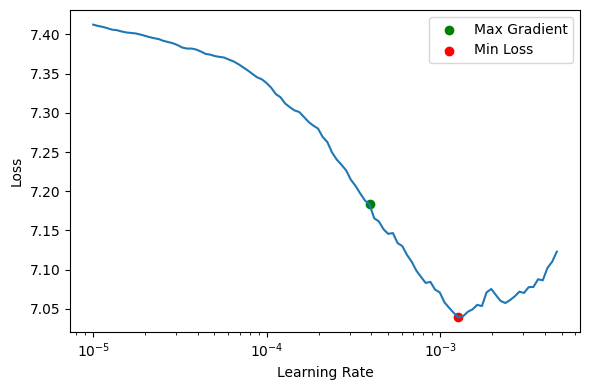

In [8]:
learner.lr_range_test(end_lr=5e-3, start_lr=1e-5)

In [9]:
learner.train(30)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | LR: 1.0E-04 | train_loss: 6.516 | valid_loss: 3.668 
train_metric: {'accuracy': 0.088, 'top_5_accuracy': 0.275, 'accuracy_super': 0.197}
valid_metric: {'accuracy': 0.127, 'top_5_accuracy': 0.386, 'accuracy_super': 0.255}
----------------------------------------------------------------------------------------------------
Epoch: 2 | LR: 1.0E-04 | train_loss: 5.696 | valid_loss: 3.291 
train_metric: {'accuracy': 0.163, 'top_5_accuracy': 0.422, 'accuracy_super': 0.302}
valid_metric: {'accuracy': 0.205, 'top_5_accuracy': 0.478, 'accuracy_super': 0.351}
----------------------------------------------------------------------------------------------------
Epoch: 3 | LR: 1.0E-04 | train_loss: 5.028 | valid_loss: 2.833 
train_metric: {'accuracy': 0.241, 'top_5_accuracy': 0.539, 'accuracy_super': 0.393}
valid_metric: {'accuracy': 0.275, 'top_5_accuracy': 0.594, 'accuracy_super': 0.431}
----------------------------------------------------------------------------------------------------
E

## Cifar-100 Leaderboard

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/cifar100_leaderboard_noextra.png?raw=true">

## Conclusion

Inception increases the network space from which the best network is to be chosen via training. Each inception module can capture salient features at different levels. Global features are captured by the 5x5 conv layer, while the 3x3 conv layer is prone to capturing distributed features. The max-pooling operation is responsible for capturing low-level features that stand out in a neighborhood. At a given level, all of these features are extracted and concatenated before it is fed to the next layer. We leave for the network/training to decide what features hold the most values and weight accordingly. Say if the images in the data-set are rich in global features without too many low-level features, then the trained Inception network will have very small weights corresponding to the 3x3 conv kernel as compared to the 5x5 conv kernel.

GoogleNet is much more concise, the size of a pre-trained VGG16 model is 528 MB, and that of a VGG19 model is 549 MB, whereas the size of a pre-trained GoogleNet is 96 MB & InceptionV3 is 92 MB.

GoogleNet achieves higher efficiency by compressing the input image and simultaneously retaining the important features/information.

## Checkpoint Saving

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
learner.save_checkpoint('googlenet_cifar100.pt')

In [13]:
import shutil
shutil.copy('googlenet_cifar100.pt', 'gdrive/MyDrive/ssmodel/googlenet_cifar100.pt')

'gdrive/MyDrive/ssmodel/googlenet_cifar100.pt'

In [14]:
learner.load_checkpoint('gdrive/MyDrive/ssmodel/googlenet_cifar100.pt')